# Introduction to StrAss-PINN

## Software prerequisite

In [1]:
try:
    from utils import *
    from netCDF4 import Dataset as d
    import torch
    from torch.utils.data import DataLoader, Dataset
    from PIL import Image
    from torchvision.transforms import Resize, Compose, ToTensor, Normalize
    import numpy as np
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt
    import matplotlib.animation as anim
    import os
    
    print("All packages are installed!")
except ImportError as e:
    print(f"An error occurred: {e}. Please make sure all required packages are installed.")

All packages are installed!


In [2]:
def grab(var):
    return var.detach().cpu().numpy()

## Load the dataset

In [3]:
# Read params.in
with open('Data/Dataset_oceano/params.in', 'r') as f:
    params_data = f.readlines()
    
for line in params_data[1:]:
    print(line)

# Read vars.nc
nc_file = 'Data/Dataset_oceano/vars.nc'
nc_dataset = d(nc_file, 'r')

# Save the variables of interest
variable_data = nc_dataset.variables['psi'][:]
x = nc_dataset.variables['x'][:]
y = nc_dataset.variables['y'][:]

nc_dataset.close()

# input parameter file

# double gyre 

NX  = 512

NY  = 512

nl = 3

Lx = 4000e3

f0 = 9.4e-05

beta = 1.7e-11

tau0 = 1.3e-5

forc_mode = 2.0



# bc_fac = 0: free slip, 1: no slip, [0..1]: partial slip

bc_fac = 0.

# dh must be an array

dh = [350., 750., 2900.]

N2 = [4.54545455e-05, 6.84931507e-06]



nu = 40

hEkb = 2



# timestepping

#tend  = 6307200000 # 200 years

#dt_out = 2592000 # 30 days

dt_out = 86400 # 1 days

tend  = 31536000 # 1 year



In [4]:
path_config = "./utils/Config.yaml"
params = YParams(os.path.abspath(path_config), "LESS_ARGO", print_params=True)

------------------ Configuration ------------------
nb_buoys 500
nb_int 50000
batch_size_int 5000
nb_bot 5000
batch_size_bot 500
name Few ARGO set-up
hidden_layers 2
nb_neurons 125
wt 1.5
kx 10
timescale 22
LAM [0, 0.0005, 1]
nb_epochs 1000
nb_rounds 3
num_workers 5
lr 0.0001
noise_strength 0
save_every 100
log_every 5
print_every 50
val_every 50
home /Long_learning_500
use_wandb True
img_size 513
t_size 100
batch_size_reg 100000
nb_reg 1300000
nb_surface 392470
batch_size_surf 30190
mean -0.1623
std 6546.083
---------------------------------------------------


In [5]:
def get_flow_tensor(sidelen, timelen, level):
    img = Image.fromarray(variable_data[0:10*timelen:10][:, level].reshape(513*timelen, 513))
    transform = Compose([
        Resize((timelen*sidelen, sidelen)),
        ToTensor()
    ])
    img = transform(img)
    img = img.reshape(timelen, sidelen, sidelen)
    return img

def get_grid(sidelen, timelen):
    """
        Définit la grille (x, y, t)
    """
    x = torch.linspace(-1, 1, steps=sidelen)
    y = torch.linspace(-1, 1, steps=sidelen)
    t = torch.linspace(-1, 1, steps=timelen)
    mgrid = torch.stack(torch.meshgrid(t, x, y, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, 3)
    mgrid = torch.stack((mgrid[:, 0], mgrid[:, 2], mgrid[:, 1]), dim=-1)
    return mgrid

def get_data():
    data_psi1 = torch.load('Data/Dataset_oceano_masked/psi1_128_100j', weights_only=False)

    mask = torch.load('Data/Dataset_oceano_masked/mask_128_100j', weights_only=False)
    coords = torch.load('Data/Dataset_oceano_masked/coords_128_100j', weights_only=False)
    std = torch.load('Data/Dataset_oceano_masked/std_128_100j', weights_only=False)
    return data_psi1, coords, mask, std

## Define the networks

In [6]:
wt = 1.5
kx = 10

device = torch.device("mps") if torch.mps.is_available() else torch.device("cpu")

psi1 = Siren(in_features=3, out_features=1, hidden_features=64, hidden_layers=2, outermost_linear=True,
             first_omega_0=3*kx, omega_0_t=3*wt).to(device)
psi2 = Siren(in_features=3, out_features=1, hidden_features=64, hidden_layers=2, outermost_linear=True,
             first_omega_0=3*kx, omega_0_t=3*wt).to(device)
psi3 = Siren(in_features=3, out_features=1, hidden_features=64, hidden_layers=2, outermost_linear=True,
             first_omega_0=3*kx, omega_0_t=3*wt).to(device)

## Define the training dataset for $\tilde{\Psi}_1$

In [7]:
params["img_size"] = 128
params["t_size"] = 10
params["round"] = 1

nb_surface = 203901 # Number of observation points at the surface
nb_buoys = 500
sample_every = 22

params["nb_int"] = 5000
params["nb_bot"] = 500
params["home"] = ""
params["end"] = "_tuto"

In [8]:
params["batch_size_surf"] = nb_surface//10
params["batch_size_int"] = params["nb_int"]//10
params["batch_size_int"] = params["nb_bot"]//10
params["batch_size_reg"] = 2048

obs1, _ = get_dataloader_surf(params, gd=get_data)

In [ ]:
nb_epochs = 200

optim = torch.optim.Adam(lr=1e-3, params=psi1.parameters())

pbar = tqdm(range(nb_epochs))

loglossdata_1 = []
loglossdyn_1 = []

lam = 0.0005

for epoch in pbar:
    for input_data, gt_psi1 in obs1:
        input_data, gt_psi1 = input_data.to(device), gt_psi1.to(device)
        input_reg = torch.zeros(params.batch_size_reg, 3).uniform_(-1, 1).to(device)
        forc = wind_forc(input_reg)
        
        output_data, _ = psi1(input_data)
        loss_data = ((output_data[:, 0].clone() - gt_psi1) ** 2).mean()
        
        output_reg, coords = psi1(input_reg)
        loss_dyn = lam*((dyn_psi1_0(params.std*output_reg, coords, forc) ** 2).mean())

        loss = loss_data + loss_dyn

        optim.zero_grad()
        loss.backward()
        optim.step()

        loglossdata_1.append(loss_data.cpu().detach().numpy())
        loglossdyn_1.append(loss_dyn.cpu().detach().numpy())

        pbar.set_description("Total loss : %0.6f. Progress " % loss.cpu().detach().numpy())

print("Psi_1 DONE")

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

loglossdata_1, loglossdyn_1 = np.array(loglossdata_1), np.array(loglossdyn_1)

ax1.plot(np.log10(np.abs(loglossdata_1)), label=r"Data loss for $\psi_1$")
ax1.plot(np.log10(np.abs(loglossdyn_1)), label=r"Dyn loss for $\psi_1$")
ax1.legend()

ax2.plot(np.log10(np.abs(loglossdata_1+loglossdyn_1)), label=r"Total loss for $\psi_1$")
ax2.legend()
ax2.set_title("This has not converged yet !");

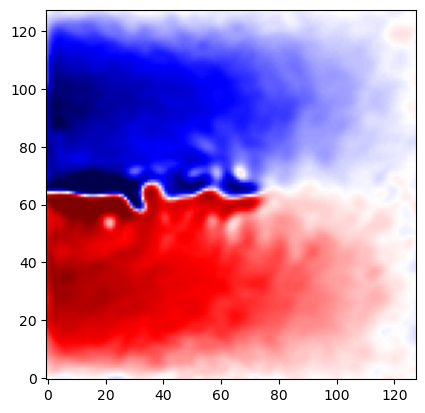

In [11]:
coords = get_grid(128, 10).to(device)
res_1 = grab(psi1(coords)[0])
v = np.quantile(res_1, 0.99)

plt.imshow(res_1.reshape(10, 128, 128)[0], cmap="seismic", vmin=-v, vmax=v, origin="lower")

## Repeat for $\tilde{\Psi}_2$ and $\tilde{\Psi}_3$ propagating information downward

In [12]:
obs2, _, _ = get_dataloader_int(params, psi1)

In [18]:
len(obs2)

1

In [13]:
nb_epochs = 200

optim = torch.optim.Adam(lr=1e-3, params=psi2.parameters())

pbar = tqdm(range(nb_epochs))

loglossdata_2 = []
loglossdyn_2 = []

best = 1000

for epoch in pbar:
    for input_data, gt_psi2 in obs2:
        input_data, gt_psi2 = input_data.to(device), gt_psi2.to(device)        
        output_data, _ = psi2(input_data)

        input_reg = torch.zeros(params.batch_size_reg, 3).uniform_(-1, 1).to(device)
        output_reg, coords = psi2(input_reg)

        output_surf, coords1 = psi1(input_reg)
        gradpsi1 = gradient(output_surf, coords1)
        lappsi1 = divergence(gradpsi1, coords1).detach()
        gradpsi1 = gradpsi1.detach()

        loss_data = ((output_data - gt_psi2) ** 2).mean()
        loss_dyn = lam*((dyn_psi2_0(params.std*output_reg, coords, gradpsi1, lappsi1) ** 2).mean())
        loss = loss_data + loss_dyn

        optim.zero_grad()
        loss.backward()
        optim.step()

        loglossdata_2.append(loss_data.cpu().detach().numpy())
        loglossdyn_2.append(loss_dyn.cpu().detach().numpy())

        pbar.set_description("Total loss %0.6f. Progress " % loss)

print("Psi_2 DONE")

  0%|          | 0/200 [00:00<?, ?it/s]

Psi_2 DONE


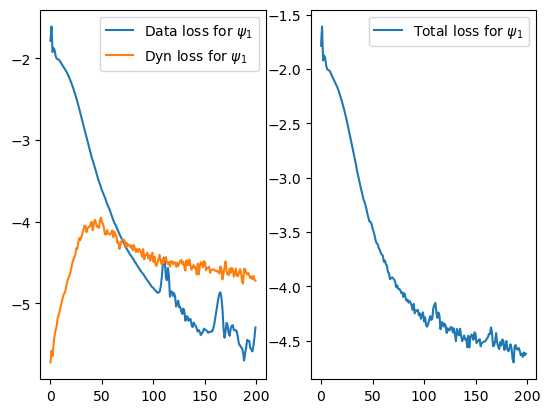

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

loglossdata_2, loglossdyn_2 = np.array(loglossdata_2), np.array(loglossdyn_2)

ax1.plot(np.log10(np.abs(loglossdata_2)), label=r"Data loss for $\psi_2$")
ax1.plot(np.log10(np.abs(loglossdyn_2)), label=r"Dyn loss for $\psi_2$")
ax1.legend()

ax2.plot(np.log10(np.abs(loglossdata_2+loglossdyn_2)), label=r"Total loss for $\psi_2$")
ax2.legend()

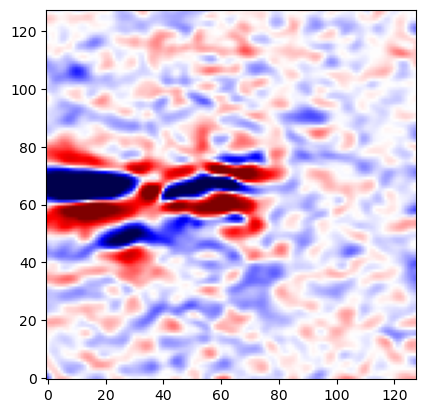

In [15]:
coords = get_grid(128, 10).to(device)
res_2 = grab(psi2(coords)[0])
v = np.quantile(res_2, 0.99)

plt.imshow(res_2.reshape(10, 128, 128)[0], cmap="seismic", vmin=-v, vmax=v, origin="lower")

In [16]:
obs3, _, _ = get_dataloader_bot(params, psi2)

In [17]:
nb_epochs = 200

optim = torch.optim.Adam(lr=1e-4, params=psi3.parameters())

pbar = tqdm(range(nb_epochs))

loglossdata_3 = []
loglossdyn_3 = []

best = 1000

for epoch in pbar:
    for input_data, gt_psi3 in obs3:
        input_data, gt_psi3 = input_data.to(device), gt_psi3.to(device)
        output_data, _ = psi3(input_data)

        input_reg = torch.zeros(params.batch_size_reg, 3).uniform_(-1, 1).to(device)
        output_reg, coords = psi3(input_reg)

        output_int, coords2 = psi2(input_reg)
        gradpsi2 = gradient(output_int, coords2)
        lappsi2 = divergence(gradpsi2, coords2).detach()
        gradpsi2 = gradpsi2.detach()

        loss_data = ((output_data - gt_psi3) ** 2).mean()
        loss_dyn = lam*((dyn_psi3(params.std*output_reg, coords, gradpsi2, lappsi2) ** 2).mean())
        loss = loss_data + loss_dyn

        optim.zero_grad()
        loss.backward()
        optim.step()

        loglossdata_3.append(loss_data.cpu().detach().numpy())
        loglossdyn_3.append(loss_dyn.cpu().detach().numpy())

        pbar.set_description("Total loss %0.6f. Progress " % loss)
        
print("Psi_3 DONE")

  0%|          | 0/200 [00:00<?, ?it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/emulation/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/emulation/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/emulation/lib/python3.12/site-packages/torch/__init__.py", line 367, in <module>
    from torch._C import *  # noqa: F403
    ^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 463, in _lock_unlock_module
KeyboardInterrupt
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/emulation/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anac

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

loglossdata_3, loglossdyn_3 = np.array(loglossdata_3), np.array(loglossdyn_3)

ax1.plot(np.log10(np.abs(loglossdata_3)), label=r"Data loss for $\psi_3$")
ax1.plot(np.log10(np.abs(loglossdyn_3)), label=r"Dyn loss for $\psi_3$")
ax1.legend()

ax2.plot(np.log10(np.abs(loglossdata_3+loglossdyn_3)), label=r"Total loss for $\psi_3$")
ax2.legend()

In [ ]:
coords = get_grid(128, 10).to(device)
res_3 = grab(psi3(coords)[0])
v = np.quantile(res_3, 0.99)

plt.imshow(res_3.reshape(10, 128, 128)[0], cmap="seismic", vmin=-v, vmax=v, origin="lower")